Instructions for students:

Since this notebook is shared, any changes you make will not be saved unless you create your own copy of this notebook in your google drive. To do this, click on 'File' and click 'Save a copy in Drive'. A new tab will open that will point to your own local copy of this notebook. You can now make changes and your modifications would be saved in your own google drive.

Run each cell in this notebook, one by one, reading the comment above the cell first. This will aid in understanding what the code is doing.

After running all cells, try changing the network architecture. Try adding more layers or changing the number of units in the layer. Can you achieve a higher accuracy?

# Multiclass Classification in Tensorflow

## Classifying Reuters newswires

We will create a neural network to classify Reuters newswires into 46 topics. Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class.

### The Reuters dataset

**Loading the Reuters dataset**

For more information on the dataset goto:
https://paperswithcode.com/dataset/reuters-21578 and

https://huggingface.co/datasets/reuters21578

This is a dataset of 11,228 newswires from Reuters, labeled over 46 topics. The dataset contains more of some topics than others so it is not equally balanced, however there are atleast 10 examples of each topic in the training set.

This was originally generated by parsing and preprocessing the classic Reuters-21578 dataset.

This dataset is packaged with Keras and has already been pre-processed for you, i.e., the words have already been converted into sequences of integers as we will show below.

We specifiy num_words = 10000, this means that we only want to keep the top 10000 most frequently occurring words in the training data and rare words would be discarded. The reason for this is so we have a fixed vector of 10000 going into our neural network later on, and also to keep things at a maneagable size.

In [1]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


Lets inspect the data.

Executing the cell below, we see that the total number of records in the training dataset is 8982 rows.

We can also see that the first movie review at index 0 is a sentence containing 87 words.

The actual data in the first record (at index 0) contains a sentence where each word has been converted to an integer. This integer corresponds to a word in a word-dictionary.

In [2]:
print(len(train_data))
print(len(train_data[0]))
print(train_data[0])

8982
87
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


The testing split contains 2246 examples.

In [3]:
len(test_data)

2246

Lets inspect the labels. We see that the corresponding label for the newswire we viewed above has a value of 3.

In [4]:
train_labels[0]

3

**Decoding newswires back to text**

Convert the word indices of the review at index 0 of the training dataset back to a string sentence. Now we can read the review. We will replace missing words with a question mark. Remember we only kept the most frequently used words and discarded the rest.

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])
print(decoded_newswire)

550378/550378 [==============================] - 0s 0us/step
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Preparing the data

**Encoding the input data**

**Encoding the integer sequences via multi-hot encoding**

You cannot pass the training data just yet to the neural network. Each newswire has different lengths. Lets turn them into a vector of zeros and ones and convert the sequence into a 10000-dimensional vector.

For example, if a sequence contained the words 'Very good' and its integer sequence in our training dataset was [10, 15] (10=very and 15=good). When we convert this sequence to a 10000 dimensional vector, all would be 0's except for indices 10 and 15.

In [6]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

One-hot encoding is a technique used to represent categorical data in a format that is suitable for machine learning algorithms, particularly for tasks like classification. In the context of labels, one-hot encoding is used to represent categorical labels as binary vectors.

Here's how one-hot encoding works:

    Initial Label Encoding: Suppose you have a set of labels, each belonging to a different category (e.g., "cat", "dog", "bird"). Each label is initially represented as an integer value (e.g., 0, 1, 2).

    Conversion to Binary Vectors: For each label, a binary vector of length equal to the number of categories is created. This binary vector has a length equal to the number of categories, and all elements are set to 0 except for the index corresponding to the category of the label, which is set to 1.

    Example:
        If you have three categories: "cat", "dog", "bird"
        The label "cat" would be encoded as [1, 0, 0]
        The label "dog" would be encoded as [0, 1, 0]
        The label "bird" would be encoded as [0, 0, 1]

One-hot encoding ensures that categorical labels are represented in a format that is suitable for training machine learning models, particularly those that require numerical inputs. It also ensures that there is no inherent ordinal relationship between the categories, as each category is represented by an independent binary value.

One-hot encoding is commonly used in tasks such as classification, where the output needs to be a categorical variable, and the model needs to output probabilities for each category.

The cell below computes the one-hot encoding manually:

In [8]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

Tensorflow has a built-in way to do one-hot encoding without writing your own function:

In [9]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

### Building your model

**Model definition**

**Dense Layers**

Dense layers, also known as fully connected layers, are a fundamental component of artificial neural networks (ANNs). In a dense layer, each neuron or node in the layer is connected to every neuron in the preceding layer. This means that each neuron receives input from all the neurons in the previous layer and computes its output using a weighted sum of those inputs, followed by an activation function.

Here's a breakdown of how a dense layer operates:

    Input: Each neuron in the dense layer receives input from all the neurons in the preceding layer. If the preceding layer has n neurons, then each neuron in the dense layer receives n inputs.

    Weights: Each input to a neuron is associated with a weight. These weights determine the strength of the connection between the neurons. The weights are learned during the training process through techniques like gradient descent.

    Weighted Sum: The inputs are multiplied by their corresponding weights, and the results are summed up. This computation can be represented mathematically as:
    weighted_sum=∑i=1ninputi×weightiweighted_sum=∑i=1n​inputi​×weighti​

    Bias: A bias term is often added to the weighted sum before applying the activation function. The bias term allows the model to capture shifts in the data that are independent of the input features.

    Activation Function: The weighted sum (optionally plus bias) is passed through an activation function, which introduces non-linearity to the output of the neuron. Common activation functions include sigmoid, tanh, ReLU (Rectified Linear Unit), and softmax.

The output of a dense layer is typically a vector, with each element representing the output of one neuron in the layer. Dense layers are versatile and can be used in various neural network architectures, including feedforward neural networks (where layers are arranged sequentially), convolutional neural networks (CNNs), and recurrent neural networks (RNNs). They are often used in the final layers of a network for tasks such as classification or regression.

**ReLU**

ReLU (Rectified Linear Unit) is an activation function commonly used in artificial neural networks. It introduces non-linearity to the output of neurons, allowing neural networks to learn complex patterns and relationships in data. The ReLU function is defined as:

f(x)=max⁡(0,x)f(x)=max(0,x)

In other words, the output of the ReLU function is the maximum of 0 and the input xx. Visually, this function looks like a ramp, where any negative input is flattened to 0, while positive inputs remain unchanged.

Here are some key characteristics of the ReLU activation function:

    Simplicity: ReLU is simple and computationally efficient. It avoids the computational cost associated with more complex activation functions like sigmoid or tanh.

    Sparsity: ReLU introduces sparsity in the network because any negative input is mapped to 0. This sparsity can be beneficial for regularization, as it helps prevent overfitting by reducing the co-adaptation of neurons.

    Non-linearity: Although ReLU is a linear function for positive inputs, it introduces non-linearity overall. This non-linearity is crucial for enabling neural networks to approximate complex functions.

    Vanishing Gradient: ReLU helps alleviate the vanishing gradient problem, which can occur with activation functions like sigmoid and tanh. The gradient of ReLU is 1 for positive inputs, which prevents the gradients from becoming too small during backpropagation.

**Softmax**

The softmax activation function is commonly used in neural networks for multi-class classification problems. It is particularly useful when the goal is to output probabilities for each class, with the constraint that the probabilities sum up to one.

Mathematically, the softmax function takes a vector of real-valued scores (also known as logits) as input and normalizes it into a probability distribution over multiple classes. The output of the softmax function is a vector where each element represents the probability of the corresponding class.

Key properties of the softmax function include:

    Output Probability Distribution: The output of the softmax function is a probability distribution, meaning that all values are between 0 and 1, and they sum up to 1. This makes it suitable for multi-class classification problems.

    Scale Invariance: Softmax is scale-invariant, meaning that adding or subtracting a constant from the input vector does not change the output probabilities. This property is useful for numerical stability during training.

    Differentiation: Softmax is differentiable, allowing for efficient gradient-based optimization techniques such as backpropagation to be applied during neural network training.

The softmax function is commonly used as the output activation function in the final layer of a neural network for multi-class classification tasks. It transforms the raw output of the neural network into a probability distribution over the different classes, making it easier to interpret and use for decision-making.

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1234)
np.random.seed(1234)

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In this step, we set the optimizer used for back propagation and the objective function(also called Loss function or Cost Function) of the network.
We also want tensorflow to monitor the accuracy of the network for us during training.

In [11]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

The validation set is used to evaluate the performance of the model during training on data that it hasn't seen before. By monitoring the model's performance on the validation set, you can make decisions about hyperparameters, such as the learning rate, batch size, and architecture, to improve the model's generalization ability without overfitting to the training data.

Preventing Overfitting: Overfitting occurs when a model learns to perform well on the training data but fails to generalize to unseen data. By evaluating the model's performance on a separate validation set, you can detect when the model starts to overfit and take corrective actions, such as early stopping or regularization techniques.

Hyperparameter Tuning: The validation set is often used in conjunction with techniques like grid search or random search to search for the optimal hyperparameters of the model. By training and evaluating the model with different hyperparameter configurations on the validation set, you can identify the settings that result in the best performance.

Monitoring Training Progress: Monitoring the model's performance on the validation set allows you to track the training progress and detect issues such as learning stagnation or divergence early on. This information can be used to adjust the training process or troubleshoot potential problems.

Overall, the validation set plays a crucial role in training neural networks effectively by providing an unbiased estimate of the model's performance and guiding decisions related to model selection, hyperparameter tuning, and training monitoring.

In [12]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]


**Training your model**

In neural network training, an epoch refers to one complete pass through the entire training dataset. During each epoch, the neural network is trained on all the training samples, typically in batches, with the goal of updating the model's parameters (weights and biases) to minimize the loss function.

Here's how the training process typically works across epochs:

    Initialization: At the start of training, the model parameters are initialized randomly or using pre-trained weights (in the case of transfer learning).

    Epoch Loop: During each epoch, the training dataset is divided into batches, and the model is trained on each batch sequentially. The order in which the batches are presented to the model can vary between epochs, depending on the shuffling of the dataset.

    Batch Training: For each batch, the model receives input data and corresponding labels. It performs forward propagation to compute the predicted outputs, then calculates the loss between the predicted outputs and the true labels. Afterward, it performs backward propagation (backpropagation) to compute the gradients of the loss function with respect to the model parameters.

    Parameter Update: Using the computed gradients, the optimizer updates the model parameters (weights and biases) in the direction that reduces the loss function. The optimizer may employ techniques like stochastic gradient descent (SGD), Adam, RMSprop, or others to perform this parameter update.

    Validation: After completing one pass through the entire training dataset (one epoch), the model's performance is typically evaluated on a separate validation dataset. This helps monitor the model's generalization ability and detect overfitting.

    Repeat: The training process continues for a predefined number of epochs or until a stopping criterion is met (e.g., convergence or early stopping based on the validation performance).

Training a neural network typically involves multiple epochs to allow the model to learn from the training data iteratively and refine its parameters over time. The number of epochs is a hyperparameter that needs to be carefully chosen, balancing the risk of overfitting (too many epochs) with the risk of underfitting (too few epochs).

In [13]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 7s 247ms/step - loss: 2.6672 - accuracy: 0.4853 - val_loss: 1.8066 - val_accuracy: 0.6140
Epoch 2/20
16/16 [==============================] - 2s 147ms/step - loss: 1.5290 - accuracy: 0.6763 - val_loss: 1.4006 - val_accuracy: 0.6910
Epoch 3/20
16/16 [==============================] - 2s 143ms/step - loss: 1.2006 - accuracy: 0.7429 - val_loss: 1.2417 - val_accuracy: 0.7280
Epoch 4/20
16/16 [==============================] - 1s 60ms/step - loss: 0.9892 - accuracy: 0.7912 - val_loss: 1.1310 - val_accuracy: 0.7560
Epoch 5/20
16/16 [==============================] - 1s 82ms/step - loss: 0.8326 - accuracy: 0.8217 - val_loss: 1.0672 - val_accuracy: 0.7660
Epoch 6/20
16/16 [==============================] - 1s 72ms/step - loss: 0.6971 - accuracy: 0.8533 - val_loss: 1.0064 - val_accuracy: 0.7850
Epoch 7/20
16/16 [==============================] - 1s 81ms/step - loss: 0.5853 - accuracy: 0.8761 - val_loss: 0.9494 - val_accuracy: 0.8030
Epoch 8/20

**Plotting the training and validation loss**

Overfitting and underfitting are common problems encountered in machine learning, including neural network training:

    Overfitting:
        Overfitting occurs when a model learns to perform exceptionally well on the training data but fails to generalize to new, unseen data. In other words, the model captures noise and patterns specific to the training data, rather than the underlying relationship between features and the target variable.
        Signs of overfitting include high accuracy on the training data but poor performance on validation or test data.
        Causes of overfitting can include overly complex models, insufficient regularization, noisy data, or a lack of diverse training data.
        Techniques to combat overfitting include:
            Simplifying the model architecture (e.g., reducing the number of parameters, using simpler model types).
            Adding regularization techniques such as L1 or L2 regularization, dropout, or early stopping.
            Increasing the amount of training data or improving its quality.
            Using techniques like cross-validation to evaluate model performance more robustly.

    Underfitting:
        Underfitting occurs when a model is too simple to capture the underlying structure of the data. The model performs poorly not only on the training data but also on new data because it fails to capture the relationships between features and the target variable.
        Signs of underfitting include poor performance on both training and validation or test data.
        Causes of underfitting can include using a model that is too simple, not training the model for a sufficient number of epochs, or insufficient feature engineering.
        Techniques to address underfitting include:
            Increasing the complexity of the model by adding more layers, neurons, or parameters.
            Training the model for more epochs or using more sophisticated optimization techniques.
            Improving feature engineering to provide the model with more relevant information.

In summary, overfitting occurs when a model learns the noise in the training data, while underfitting occurs when a model fails to capture the underlying patterns in the data. Both problems can lead to poor generalization performance and should be addressed during model development and training. Regularization techniques and model evaluation on separate validation or test datasets are essential tools for managing overfitting and underfitting.

Observing the graphs below, we see that the model beings to overfit after nine epochs.

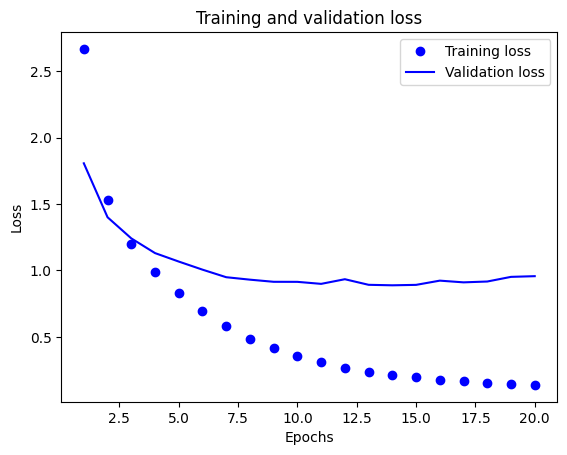

In [14]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

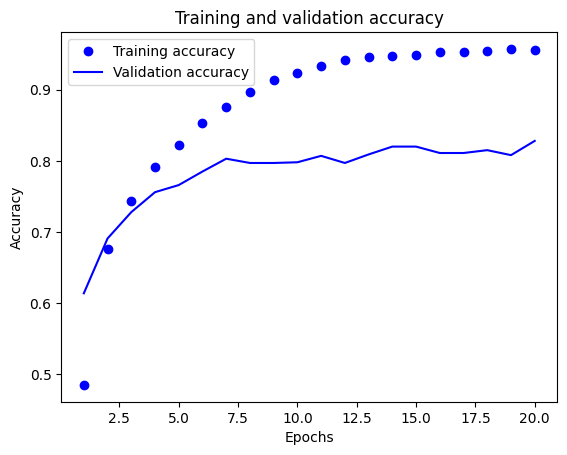

In [15]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

We observed above from the graphs above that the model overfit after nine epochs. Lets set this to 9 epochs and train again.

Note: We are only doing this training step twice as a learning exercise to see where the model overfits and then training an optimal model. We do not want to make predictions on a model thats overfitting as we expect that model to have much poorer performance.

For example, in the above graphs, we observe that the model overfits after 9 epochs. Afterwards, generalisation performance on the validation set flatlines. If we retrain a new model for 17 epochs, we can expect worse results since the model is overfitting (observe the dip on the graph at 17 epochs).

In reality, this isn't a 2-step training process. Tensorflow has an Early-stopping mechanism that automatically stops training and returns the optimal model weights (or the optimal model) when the model begins to overfit. We will look at this later on in the module.

In [16]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 44ms/step - loss: 2.6921 - accuracy: 0.5202
Epoch 2/9
18/18 [==============================] - 1s 51ms/step - loss: 1.5226 - accuracy: 0.6805
Epoch 3/9
18/18 [==============================] - 1s 49ms/step - loss: 1.1575 - accuracy: 0.7446
Epoch 4/9
18/18 [==============================] - 1s 51ms/step - loss: 0.9391 - accuracy: 0.7988
Epoch 5/9
18/18 [==============================] - 1s 73ms/step - loss: 0.7762 - accuracy: 0.8363
Epoch 6/9
18/18 [==============================] - 1s 70ms/step - loss: 0.6466 - accuracy: 0.8625
Epoch 7/9
18/18 [==============================] - 1s 66ms/step - loss: 0.5348 - accuracy: 0.8881
Epoch 8/9
18/18 [==============================] - 1s 43ms/step - loss: 0.4527 - accuracy: 0.9059
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9067 - accuracy: 0.7934


The results:
The first number is the test loss and the second number is the test accuracy.

We see that we obtained an accuracy roughly around 78~79%.

In [17]:
results

[0.9067286252975464, 0.7934104800224304]

### Generating predictions on new data

In [18]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 5ms/step


Lets view the predicted model output for the first test example.
The model out of the first example contains 46 values (shape). These are the probability values for each class. The sum of all probabilities will be ≈ 1.
The index of the highest probability value will be the predicted class (Index of maximum). This is at index 3 so the predicted label is 3.
 Inspecting the ground truth, we see that the label is also 3 which means the model made the correct prediction for this test example.

In [19]:
print(f'Shape: {predictions[0].shape}')
print(f'Probabilities: {predictions[0:45]}')
print(f'Sum: {np.sum(predictions[0])}')
print(f'Index of maximum: {np.argmax(predictions[0])}')
print(f'Ground truth label: {y_test[0]}')

Shape: (46,)
Probabilities: [[1.9572988e-05 1.1391064e-04 3.0045605e-05 ... 3.0897383e-05
  5.5056512e-06 1.0708872e-05]
 [4.1760333e-02 1.8715602e-01 5.9324075e-03 ... 1.6612081e-05
  2.6692828e-04 6.2019553e-04]
 [9.4033061e-03 8.4466887e-01 1.3098934e-03 ... 1.3190199e-04
  2.6002922e-04 3.6434698e-04]
 ...
 [9.9334575e-05 1.6350130e-03 3.3006188e-04 ... 4.3557704e-04
  2.1667096e-04 1.5466622e-04]
 [2.5225829e-04 2.3830519e-03 6.5400098e-03 ... 3.4521278e-02
  1.9428378e-05 2.5389419e-04]
 [7.6369419e-05 8.7704306e-05 9.0176782e-06 ... 2.0762111e-06
  6.2650602e-06 1.9433950e-05]]
Sum: 1.0
Index of maximum: 3
Ground truth label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### A different way to handle the labels and the loss

If you do not want to do one-hot encoding on the labels, and still keep the integer labels, all you would need to do is change the loss to sparse_categorical_crossentropy as shown below.

Reset the training labels back to normal integers:

In [20]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [21]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently larger intermediate layers

**A model with an information bottleneck**

Since the model has a output layer which is 46-dimensional, as standard practice you should generally avoid having intermediate layers with many fewer than 46 units. Lets see what happens when we purposely introduce an information bottleneck intou our neural network architecture design.

In [22]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 3s 25ms/step - loss: 3.4124 - accuracy: 0.0677 - val_loss: 2.9937 - val_accuracy: 0.0770
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 2.3302 - accuracy: 0.3593 - val_loss: 1.8150 - val_accuracy: 0.6330
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 1.4413 - accuracy: 0.6844 - val_loss: 1.4487 - val_accuracy: 0.6650
Epoch 4/20
63/63 [==============================] - 1s 20ms/step - loss: 1.1981 - accuracy: 0.7129 - val_loss: 1.3661 - val_accuracy: 0.6760
Epoch 5/20
63/63 [==============================] - 2s 24ms/step - loss: 1.0759 - accuracy: 0.7378 - val_loss: 1.3343 - val_accuracy: 0.6880
Epoch 6/20
63/63 [==============================] - 1s 22ms/step - loss: 0.9850 - accuracy: 0.7600 - val_loss: 1.3316 - val_accuracy: 0.7070
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.9110 - accuracy: 0.7767 - val_loss: 1.3018 - val_accuracy: 0.7060
Epoch 8/20
63

In [23]:
y_test = to_categorical(test_labels)
results = model.evaluate(x_test, y_test)
print(results)

71/71 [==============================] - 0s 4ms/step - loss: 1.9224 - accuracy: 0.6919
[1.9223910570144653, 0.6918966770172119]


The model performs considerably worse with a much lower accuracy than before due to information bottleneck. This happens because we are trying to compress a lot of information into an intermediate space that is too low dimensional (4 units) and then attempting to recover information from this that describes 46 classes i.e. we're trying to recover the separation hyperplanes for 46 classes.
The model performance is around 70% accuracy which means the model is actually able to cram most of the important information into these 4-dimensional respresentations but clearly not all of it since it resulted in a lower accuracy than before. Consider this when you are designing your own neural network architecture.